In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False) # by default returns a pd.DataFrame but we want np.ndarray

In [5]:
X: np.ndarray = mnist["data"]
y: np.ndarray = mnist["target"]

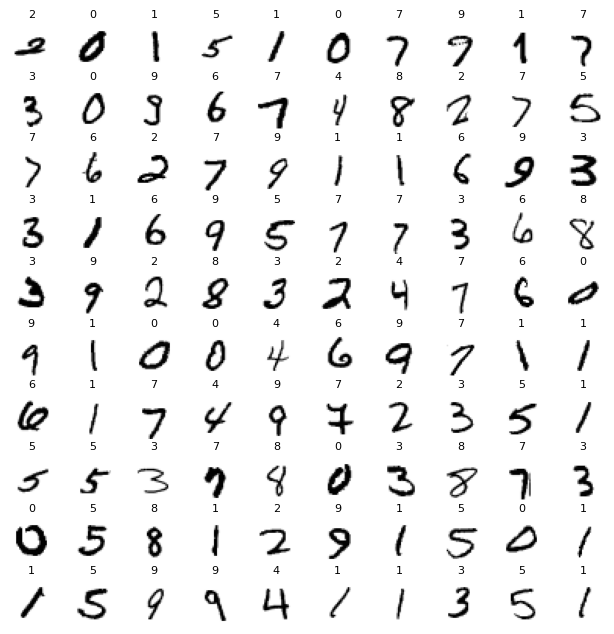

In [6]:
def plot_image(img: np.ndarray) -> None:
    image = img.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.show()

fig, axis = plt.subplots(10, 10)
fig.tight_layout(pad=-1)
fig.set_figheight(6)
fig.set_figwidth(6)

for i in range(10):
    for j in range(10):
        rand = np.random.randint(low=0, high=len(X))

        img = X[rand].reshape(28, 28)
        label = y[rand]
        ax = axis[i, j]

        ax.imshow(img, cmap="binary")
        ax.set_title(str(label), fontsize=8)
        ax.axis("off")

plt.show()

### Splitting into test and train set

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
from sklearn.linear_model import SGDClassifier

sdg_clr = SGDClassifier(loss="log_loss")

y_train_5 = y_train == '5'

sdg_clr.fit(X_train, y_train_5)

SGDClassifier(loss='log_loss')

In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sdg_clr, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9694 , 0.9541 , 0.96075])

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sdg_clr, X_train, y_train_5, cv=3)

In [11]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53283,  1296],
       [ 1141,  4280]])

In [12]:
from sklearn.metrics import precision_score, recall_score

print(f"precision = {precision_score(y_train_5, y_train_pred, zero_division="warn")}, recall = {recall_score(y_train_5, y_train_pred, zero_division="warn")}")

precision = 0.7675753228120517, recall = 0.7895222283711493


In [13]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7783941074838593

### Setting threshold for classification problem

In [14]:
y_scores_decision_func = cross_val_predict(sdg_clr, X_train, y_train_5, cv=3, method="decision_function")
# Decision function the logit function that is passed into the sigmoid function to get the log(prob)

y_scores_decision_func

array([  1797.99277441, -22178.76262585, -34499.68307358, ...,
         9064.05106491,  -5262.54980157,  -7693.35016414], shape=(60000,))

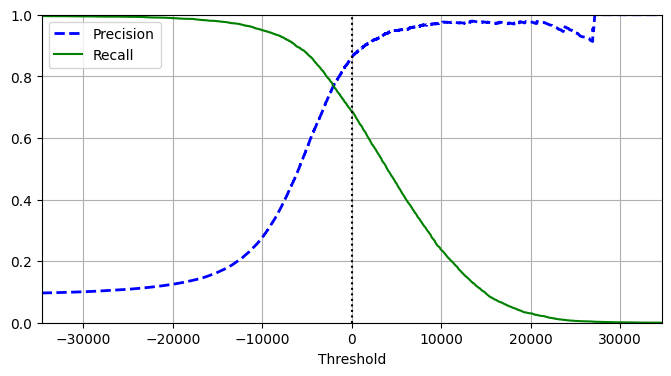

In [15]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_decision_func)
# Gives values of different precision and recall for different values thresholds to determine a good threshold value. Also, length of threshold is one less than others

plt.figure(figsize=(8, 4))
plt.grid()
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g", label="Recall")
plt.vlines(0, ymin=0, ymax=1, colors="k", linestyles="dotted")
minVal = min(-min(thresholds), max(thresholds))
plt.axis((-minVal, minVal, 0, 1.0))
plt.legend(loc="best")
plt.xlabel("Threshold")
plt.show()

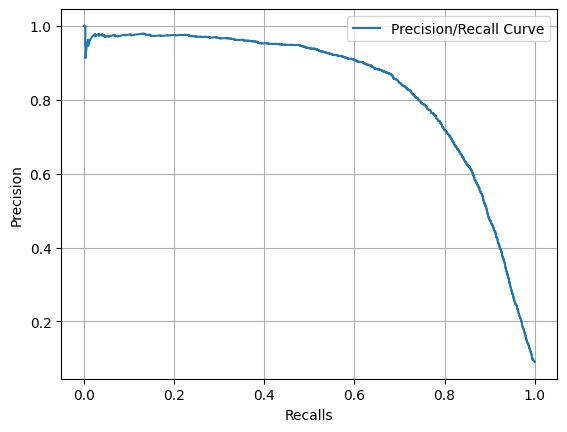

In [16]:
threshold: int = 0

plt.plot(recalls, precisions, label="Precision/Recall Curve")
plt.grid()
plt.xlabel("Recalls")
plt.ylabel("Precision")
plt.legend()
plt.show()

In [17]:
idx_for_90_precision = (precisions >= 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(1469.2713761879063)

In [18]:
y_train_pred_90 = (y_scores_decision_func >= threshold_for_90_precision)
print(precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90))

0.9001605995717344 0.6203652462645268


### Receiver operating characteristic curve

* The pointier it is on the top left the better it is
* Shows that if we increase the recall the false positive rate also increases and while decreasing the recall if false positive rate does not decrease a lot that's better
* The area under the curve of roc curve if is maximum among all other models that is better
* Roc curve finds the confusion matrix for multiple values of threshold refer [StatQuest](https://www.youtube.com/watch?v=4jRBRDbJemM&ab_channel=StatQuestwithJoshStarmerh)
* If found a threshold value that puts the point(fpr, tpr) on top left corner that is the best threshold value as it minimizes false positive and maximizes true positives

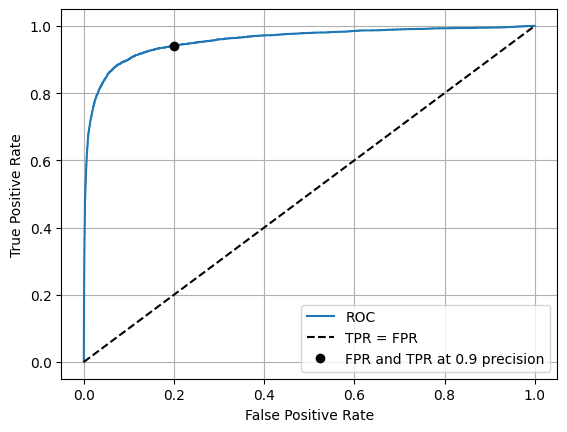

In [19]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores_decision_func)

thresholds.sort() # for roc curve

idx_for_threshold_at_90 = (thresholds >= threshold_for_90_precision).argmax()
fpr_at_90, tpr_at_90 = fpr[idx_for_threshold_at_90], tpr[idx_for_threshold_at_90]

plt.figure()
plt.plot(fpr, tpr, label="ROC")
plt.plot([0, 1], [0, 1], "k--", label="TPR = FPR")
plt.plot([fpr_at_90], [tpr_at_90], "ko", label="FPR and TPR at 0.9 precision")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()

In [20]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_train_5, y_scores_decision_func)
auc

np.float64(0.9576451004061513)

### Using RandomForestClassifier

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict

rnd_cls = RandomForestClassifier()
cross_val_score(rnd_cls, X_train, y_train_5, scoring="accuracy", cv=3)

array([0.9887 , 0.9862 , 0.98645])

In [22]:
rnd_forest_predict_prob = cross_val_predict(rnd_cls, X_train, y_train_5, cv=3, method="predict_proba")

In [23]:
from sklearn.metrics import precision_score, recall_score

rnd_forest_predict_prob_40 = rnd_forest_predict_prob[:, 1] >= 0.4
print(f"precision = {precision_score(y_train_5, rnd_forest_predict_prob_40)}, recall = {recall_score(y_train_5, rnd_forest_predict_prob_40)}, f1score = {f1_score(y_train_5, rnd_forest_predict_prob_40)}")

precision = 0.9737047136735489, recall = 0.9221545840250877, f1score = 0.9472288015158693


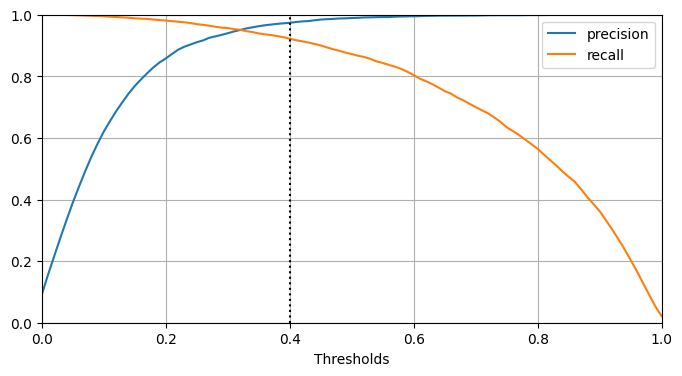

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, rnd_forest_predict_prob[:, 1])

curr_threshold = 0.4
threshold_index = (thresholds >= curr_threshold).argmax()

plt.figure(figsize=(8, 4))
plt.grid()
plt.axis((0, 1, 0, 1))
plt.plot(thresholds, precisions[:-1], label="precision")
plt.plot(thresholds, recalls[:-1], label="recall")
plt.vlines(thresholds[threshold_index], 0, 1, colors="k", linestyle="dotted")
plt.xlabel("Thresholds")
plt.legend()
plt.show()

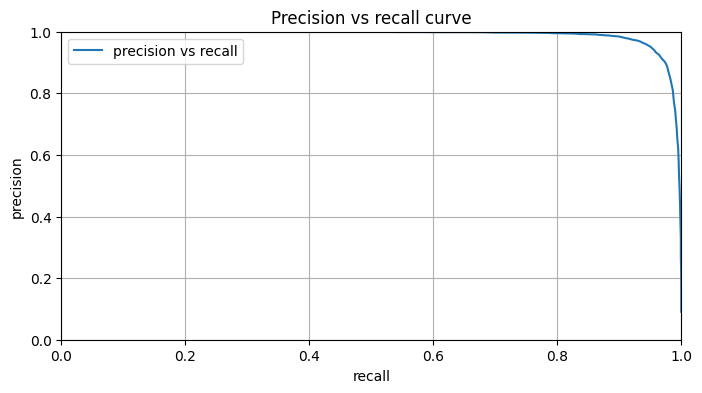

In [25]:
plt.figure(figsize=(8, 4))
plt.grid()
plt.plot(recalls, precisions, label="precision vs recall")
plt.title("Precision vs recall curve")
plt.axis((0, 1, 0, 1))
plt.legend()
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

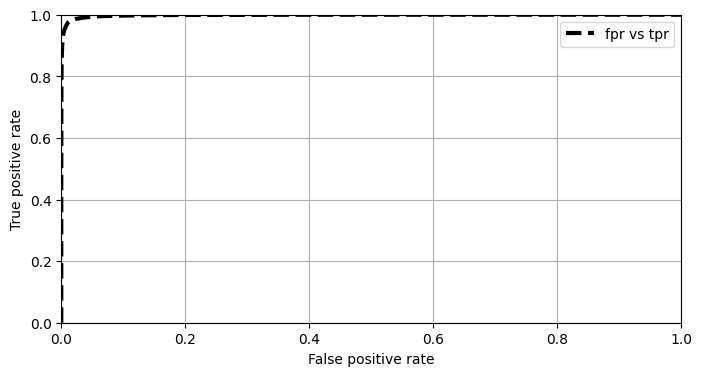

ROC AUC = 0.9983104460116925


In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, rnd_forest_predict_prob[:, 1])
plt.figure(figsize=(8, 4))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot(fpr, tpr, "k--", label="fpr vs tpr", linewidth=3)
plt.grid()
plt.axis((0, 1, 0, 1))
plt.legend()
plt.show()

print(f"ROC AUC = {roc_auc_score(y_train_5, rnd_forest_predict_prob[:, 1])}")

### Multiclass classification

In [27]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:10000], y_train[:10000])

SVC(random_state=42)

In [28]:
print(f"{svm_clf.predict([X_train[0]]) = }")
# answer is the max decision function value
print(f"decision function values = {svm_clf.decision_function([X_train[0]]).round(1)}")
print(f"{svm_clf.classes_ = }")

svm_clf.predict([X_train[0]]) = array(['5'], dtype=object)
decision function values = [[ 0.7  3.7  6.2  8.3 -0.3  9.3  1.7  3.8  7.2  3.8]]
svm_clf.classes_ = array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)


### One vs rest classification

In [29]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:10000], y_train[:10000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [30]:
print(ovr_clf.predict([X_train[0]]))
print(f"{len(ovr_clf.estimators_) = }")

['5']
len(ovr_clf.estimators_) = 10


### One vs One classification

In [31]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(estimator=SVC(random_state=42), n_jobs=5)
# ovo_clf.fit(X_train[:1000], y_train[:1000])
# print(f"{len(ovo_clf.estimators_) = }")

cross_val_score(ovo_clf, X_train[:5000], y_train[:5000], cv=2)

array([0.9404, 0.9404])

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train_scaled[:5000], y_train[:5000])

SGDClassifier()

### Error Analysis

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

pred_val = cross_val_predict(sgd_clf, X_train_scaled[:10000], y_train[:10000], cv=3, n_jobs=-1)
pred_val

array(['2', '0', '7', ..., '6', '9', '7'], shape=(10000,), dtype='<U1')

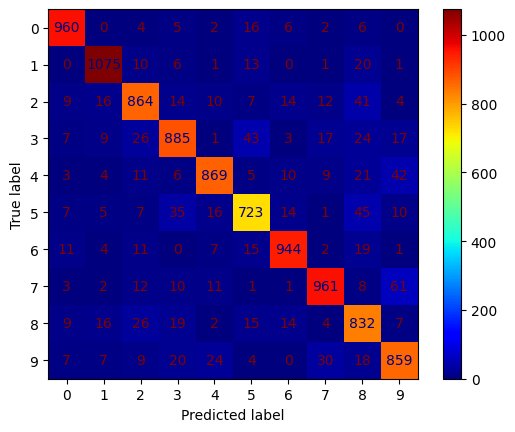

In [34]:
ConfusionMatrixDisplay.from_predictions(y_train[:10000], pred_val, cmap="jet")
plt.show()

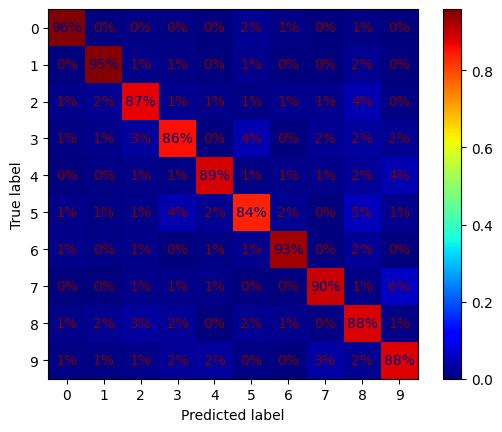

In [35]:
ConfusionMatrixDisplay.from_predictions(y_train[:10000], pred_val, cmap="jet", normalize="true", values_format=".0%")
plt.show()

### Sample weight ->

allows to specify weight for each example in the confusion matrix so if errors are provided with weight 1 and correct with weight 0 that reflects the errors even more

### Explanation -

eg (row 0, col 2) -> means out of all the errors made in identifying "0" 11% were misclassified as "2"

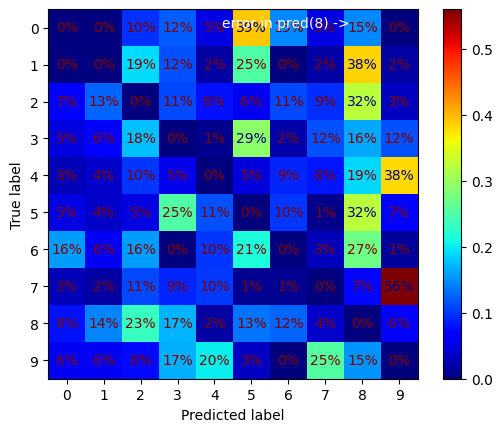

In [36]:
sample_weight = (pred_val != y_train[:10000]).astype(int)
# try this - sample_weight[0] = 5000 and see changes

ConfusionMatrixDisplay.from_predictions(y_train[:10000], pred_val, cmap="jet", normalize="true", values_format=".0%", sample_weight=sample_weight)
plt.annotate("error in pred(8) ->", xy=(4.2, 0), color="white")
plt.show()

### Explanation -

eg (1, 2) = 10% -> out of all _incorrectly_ predicted labels of 2 10% were actually 1

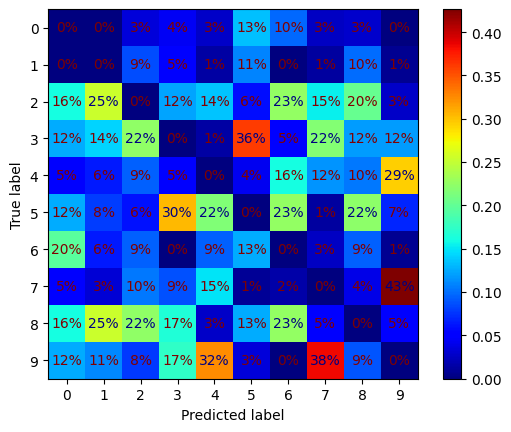

In [37]:
sample_weight = (pred_val != y_train[:10000]).astype(int)

# using normalize="pred" normalizes it by columns and true normalizes it by rows
ConfusionMatrixDisplay.from_predictions(y_train[:10000], pred_val, cmap="jet", normalize="pred", values_format=".0%", sample_weight=sample_weight)
plt.show()

### Multilabel Classification

use
- `sklearn.neighbors.KNeighborsClassifier` for direct training for all labels and then find f1_score of each label of the predicted scores
- If want to use a classifier that does not natively support multilabel classification then individually train each label however multilabel classification also uses the output of the previous predicted labels as features to determine the next label and hence when training of one label is done use the predictions as new feature for the next label. Simplified by `sklearn.multioutput.ClassifierChain`

In [38]:
from sklearn.neighbors import KNeighborsClassifier

large_values = (y_train >= '7')
odd_values = (y_train.astype(int) % 2 == 1)

y_multilabel = np.c_[large_values, odd_values]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [39]:
from sklearn.model_selection import cross_val_predict

pred_val = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [40]:
# you can also use average="weighted" for weighted f1_score where certain labels gets more priority

f1_score(y_multilabel, pred_val, average="macro")

0.9764102655606048

In [41]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(random_state=42), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(random_state=42), cv=3, random_state=42)

In [44]:
chain_clf.predict([X_train[0]])

array([[0., 1.]])

### Multioutput classification

In [48]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 28 * 28))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 28 * 28))
X_test_mod = X_test + noise

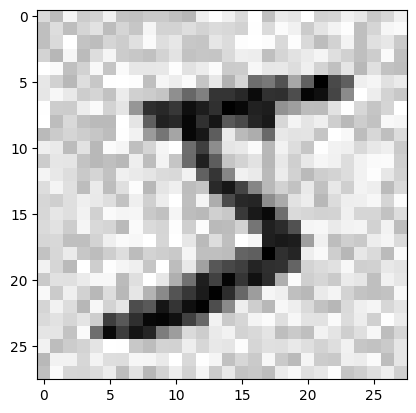

In [50]:
y_train_mod = X_train
y_test_mod = X_test

plt.imshow(X_train_mod[0].reshape(28, 28), cmap="binary")

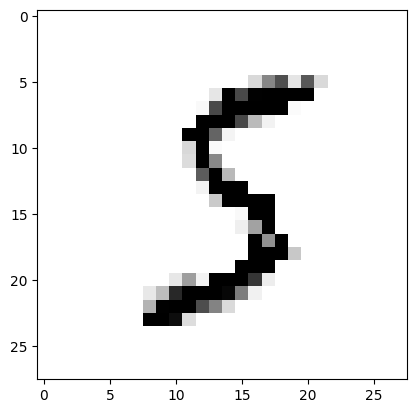

In [52]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_train_mod[0]])
plt.imshow(clean_digit.reshape(28, 28), cmap="binary")
plt.show()